# **ETA Prediction with Machine Learning**

## **Introduction**

Ride-hailing apps like Uber and Yassir rely on real-time data and machine learning algorithms to automate their services. Accurately predicting the estimated time of arrival (ETA) for Yassir trips will make Yassir’s services more reliable and attractive; this will have a direct and indirect impact on both customers and business partners. The solution would help the company save money and allocate more resources to other parts of the business.

The objective of this hackathon is to predict the estimated time of arrival at the dropoff point for a single Yassir journey.

This project will use the [CRISP-DM](https://www.datascience-pm.com/crisp-dm-2/) framework for data science problems

(Dataset : [Yassir Data](https://zindi.africa/competitions/yassir-eta-prediction-challenge-for-azubian/data))

## **1. Business Understanding**

*Predicting Estimated Time of Arrival (ETA) for Yassir Journeys*

Ride-hailing platforms such as Uber and Yassir operate in a fast-paced environment, relying on real-time data and advanced machine learning algorithms to enhance their services. In particular, accurate prediction of the Estimated Time of Arrival (ETA) for Yassir trips is crucial for improving the reliability and attractiveness of the service to both customers and business partners.

ETAs are used to calculate ride fares, estimate pickup times, match riders to drivers, plan deliveries, and much more. The estimated time of arrival should be as accurate as possible. If estimate is higher then user might cancel the order or if it is lower user might complain and uninstall the app. In both cases there is loss for the company, thus making this a key metric for their business model.

For several years, [Uber used gradient-boosted decision tree ensembles](https://www.uber.com/en-KE/blog/deepeta-how-uber-predicts-arrival-times/) to refine their ETA predictions. As their training dataset grew, Uber’s Apache Spark™ team contributed upstream improvements to XGBoost to allow the model to grow ever deeper, making it one of the largest and deepest XGBoost ensembles in the world at that time. They have since moved to a deep learning due to the ease of scaling on large datasets.

The ETA will vary due to factors such as trip distance and/or weather-related issues.

### Objectives
The  goal is to develop a predictive model capable of accurately estimating the time it takes for a Yassir journey to reach its drop-off point. By achieving this objective, Yassir aims to enhance the overall efficiency and quality of its service, providing tangible benefits to both customers and business partners.

### Hypothesis
Null Hypothesis (H0):
There is no significant relationship between ETA and trip distance.

Alternate Hypothesis (H1):
There is a significant relationship between ETA and trip distance.

## **2. Data Understanding**

### Importation
Here is the section to import all the packages/libraries that will be used through this notebook.

In [4]:
import os, joblib
from joblib import load

# Data handling
import pandas as pd
import numpy as np

# Vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#EDA
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.cluster import KMeans
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, RobustScaler, PowerTransformer
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest, f_regression


# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

### Data Loading
Here is the section to load the datasets (train, eval, test) and the additional files

In [5]:
# load training data
training = pd.read_csv(r'..\dataset\Train.csv').set_index('ID')
training['Timestamp'] = pd.to_datetime(training['Timestamp'])
training.tail()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
ID,,,,,,,
ZZXN4JH2,2019-11-30 23:21:58+00:00,3.121,36.743,3.032,36.770,10321,664
ZZXQ5AQJ,2019-11-27 05:59:31+00:00,3.024,36.749,2.951,36.735,10791,1056
ZZXYPKGU,2019-12-06 05:04:06+00:00,3.189,36.721,3.186,36.721,1139,296
ZZYTQHKT,2019-12-07 05:55:22+00:00,3.046,36.738,2.986,36.766,10637,895
ZZZY11ZN,2019-12-12 21:22:31+00:00,2.889,36.762,2.957,36.758,9363,654


In [6]:
# testing data
testing = pd.read_csv(r'..\dataset\Test.csv').set_index('ID')
testing['Timestamp'] = pd.to_datetime(testing['Timestamp'])
testing.tail()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance
ID,,,,,,
ZZXSJW3Q,2019-12-21 04:10:59+00:00,2.947,36.748,2.949,36.747,3413
ZZYPNYYY,2019-12-30 20:31:22+00:00,3.037,36.742,2.924,36.762,14341
ZZYVPKXY,2019-12-27 20:21:38+00:00,2.993,36.723,2.983,36.747,4465
ZZZXGRIO,2019-12-29 22:00:31+00:00,2.954,36.743,3.057,36.760,13105
ZZZYTWJA,2019-12-20 22:44:19+00:00,2.982,36.760,3.014,36.761,5543


In [7]:
# weather data
weather_df = pd.read_csv(r'..\dataset\Weather.csv')
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.head()

,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-11-01,290.630524,296.434662,294.125061,101853.617188,292.503998,100806.351562,0.004297,3.561323,0.941695
1,2019-11-02,289.135284,298.432404,295.551666,101225.164062,293.337921,100187.250000,0.001767,5.318593,3.258237
2,2019-11-03,287.667694,296.612122,295.182831,100806.617188,293.674316,99771.414062,0.000797,8.447649,3.172982
3,2019-11-04,287.634644,297.173737,294.368134,101240.929688,292.376221,100200.843750,0.000393,5.991428,2.236700
4,2019-11-05,286.413788,294.284851,292.496979,101131.750000,289.143066,100088.500000,0.004658,6.962730,2.655364


1. **date:** The date when the weather measurements were recorded.

2. **dewpoint_2m_temperature:** The temperature at 2 meters above the ground where the air temperature would be low enough for dew to form. It gives an indication of humidity.

3. **maximum_2m_air_temperature:** The highest air temperature recorded at 2 meters above the ground during the specified date.

4. **mean_2m_air_temperature:** The average air temperature at 2 meters above the ground during the specified date.

5. **mean_sea_level_pressure:** The average atmospheric pressure at sea level during the specified date.

6. **minimum_2m_air_temperature:** The lowest air temperature recorded at 2 meters above the ground during the specified date.

7. **surface_pressure:** The atmospheric pressure at the Earth's surface during the specified date.

8. **total_precipitation:** The total amount of precipitation (rain, snow, etc.) during the specified date.

9. **u_component_of_wind_10m:** The east-west (horizontal) component of the wind speed at 10 meters above the ground.

10. **v_component_of_wind_10m:** The north-south (vertical) component of the wind speed at 10 meters above the ground.

### Exploratory Data Analysis: EDA
Here is the section to **inspect** the datasets in depth, **present** it, make **hypotheses** and **think** the *cleaning, processing and features creation*.

In [8]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83924 entries, 000FLWA8 to ZZZY11ZN
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Timestamp        83924 non-null  datetime64[ns, UTC]
 1   Origin_lat       83924 non-null  float64            
 2   Origin_lon       83924 non-null  float64            
 3   Destination_lat  83924 non-null  float64            
 4   Destination_lon  83924 non-null  float64            
 5   Trip_distance    83924 non-null  int64              
 6   ETA              83924 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(2)
memory usage: 5.1+ MB


In [9]:
#let's check if we are missing values
training.isna().sum()

Timestamp          0
Origin_lat         0
Origin_lon         0
Destination_lat    0
Destination_lon    0
Trip_distance      0
ETA                0
dtype: int64

- no missing values

In [10]:
# format numerical columns to 2 decimal places with comma separator
pd.options.display.float_format = '{:,.3f}'.format

# statistics for numerical columns
training.describe()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
count,"83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000"
mean,3.052,36.739,3.057,36.738,"13,527.821","1,111.698"
std,0.096,0.032,0.101,0.033,"9,296.716",563.565
min,2.807,36.589,2.807,36.596,1.000,1.000
25%,2.994,36.721,2.995,36.718,"6,108.000",701.000
50%,3.046,36.742,3.049,36.742,"11,731.500","1,054.000"
75%,3.095,36.760,3.109,36.760,"19,369.000","1,456.000"
max,3.381,36.820,3.381,36.819,"62,028.000","5,238.000"


- **Origin and Destination Coordinates (Latitude and Longitude)**: The average coordinates are approximately 3.052 latitude and 36.739 longitude for both origin and destination. The minimum and maximum values show a limited range.
- **Trip Distance**: The average trip distance is approximately 13,527.82 M, with a minimum of 1.00 M and a maximum of 62,028.00 M. Some anomalies with low distance.
- **ETA (Estimated Time of Arrival)**: The average ETA is approximately 1,111.70s, with a minimum of 1.00s and a maximum of 5,238.00s. There could be some anomalies here with low ETA's.

#### Univariate Analysis

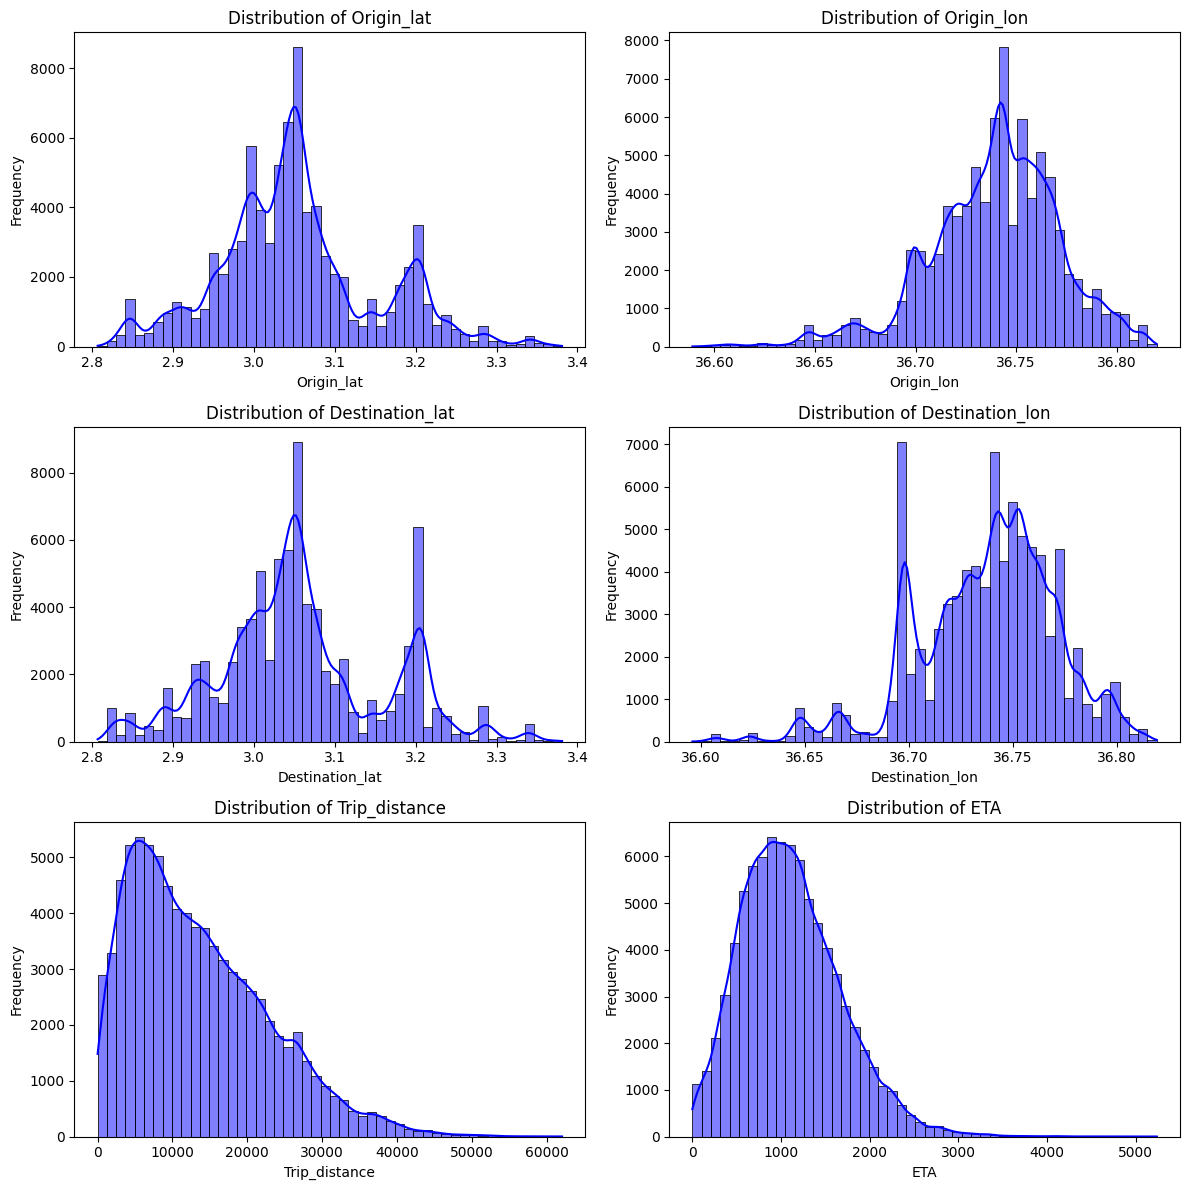

In [11]:
# Create histograms with KDE plots to visualize distribution
cols = ['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon', 'Trip_distance', 'ETA']

# Calculate the number of rows needed
num_rows = len(cols) // 2 + len(cols) % 2

# Set up subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 4 * num_rows))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Iterate over columns and create histograms with KDE plots
for i, column in enumerate(cols):
    sns.histplot(training[column], kde=True, bins=50, color='blue', ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove empty subplots if the number of subplots is odd
if len(cols) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

- The origin and destination points seem to be in the same coordinates, indicating that the majority of the trips are likely within a single geographic area. This concentration of data in a specific zone is likely associated with internal activity within a country, potentially representing a dense urban area or a hub of economic activity.

- Trip distance and ETA are positively skewed. This suggest the direction of outliers towards the upper bound of the dataset.

#### Bivariate Analysis

In [13]:
# Create a GeoDataFrame based on the origin coordinates
geometry_origin = [
    Point(lon, lat) 
    for lon, lat in zip(training['Origin_lon'], training['Origin_lat'])
]
gdf_origin = gpd.GeoDataFrame(
    training, geometry=geometry_origin, crs="EPSG:4326"
)

# Create a GeoDataFrame based on the destination coordinates
geometry_destination = [
    Point(lon, lat) 
    for lon, lat in zip(training['Destination_lon'], training['Destination_lat'])
]
gdf_destination = gpd.GeoDataFrame(
    training, geometry=geometry_destination, crs="EPSG:4326"
)

# Load Natural Earth world map (GeoPandas 1.0+ compatible)
world = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
)

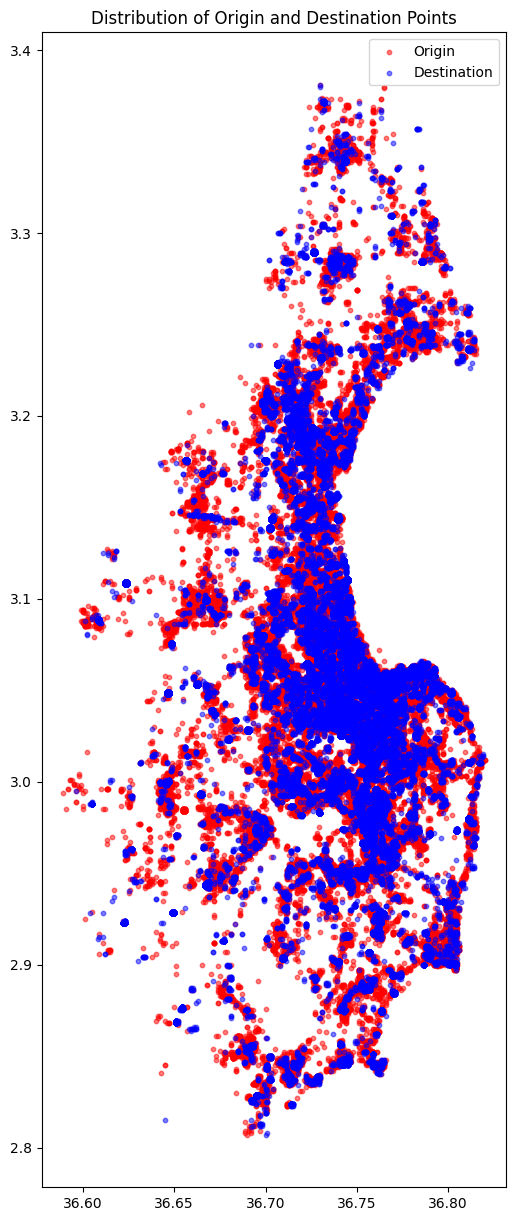

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))

gdf_origin.plot(ax=ax, color="red", markersize=10, alpha=0.5, label="Origin")
gdf_destination.plot(ax=ax, color="blue", markersize=10, alpha=0.5, label="Destination")

ax.set_title("Distribution of Origin and Destination Points")
ax.legend()
plt.show()

- the visualization of the map indeed confirms the concentration of data within a specific geographic area. The proximity of the origin and destination points, along with the clustering observed on the map, aligns with the interpretation of strong local activity.

In [17]:
# Use the geopy locator with Nominatim/OpenStreetMaps
locator = Nominatim(user_agent='myGeoencoder', timeout=60)
coordinates = ['2.981,36.688'] #check the location data for one point
location = locator.reverse(coordinates)
location.raw

{'place_id': 38296212,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
 'osm_type': 'relation',
 'osm_id': 15998068,
 'lat': '2.9318846',
 'lon': '36.7372475',
 'class': 'boundary',
 'type': 'administrative',
 'place_rank': 16,
 'importance': 0.18671166781109327,
 'addresstype': 'city',
 'name': 'Loiyangalani ward',
 'display_name': 'Loiyangalani ward, Laisamis, Marsabit, Kenya',
 'address': {'city': 'Loiyangalani ward',
  'county': 'Laisamis',
  'state': 'Marsabit',
  'ISO3166-2-lvl4': 'KE-25',
  'country': 'Kenya',
  'country_code': 'ke'},
 'boundingbox': ['2.4032423', '3.4612621', '36.2097189', '37.1789403']}

- Our datapoints are somewhere in Marsabit state, Kenya
- We can extract location data such as county and state with reverse geocoding

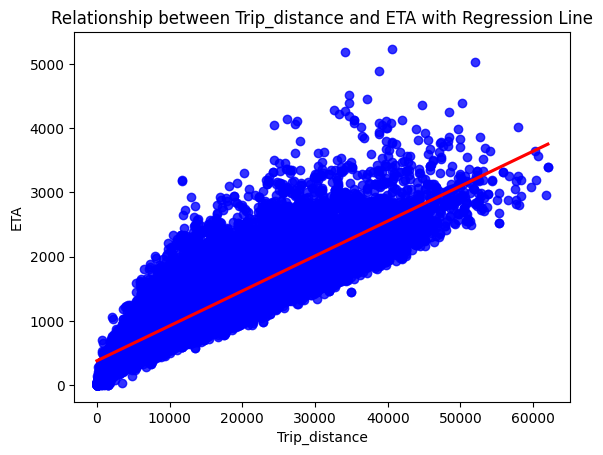

In [18]:
# check regression line
# Scatter plot with regression line
sns.regplot(x='Trip_distance', y='ETA', data=training, scatter_kws={'color':'blue'}, line_kws={'color':'red'})

# Set x-axis label
plt.xlabel('Trip_distance')

# Set y-axis label
plt.ylabel('ETA')

# Set plot title
plt.title('Relationship between Trip_distance and ETA with Regression Line')

# Show the plot
plt.show()

The analysis of the relationship between the trip distance ('Trip_distance') and the estimated time of arrival ('ETA') indicates a significant correlation, suggesting a linear trend where longer trip distances are associated with longer arrival times. However, the presence of points deviating from the regression line suggests some variability and the possibility of atypical observations.

#### Hypothesis testing

In [19]:
eta_data = training['ETA']
trip_distance_data = training['Trip_distance']

# Calculate the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(eta_data, trip_distance_data)

# Print the results
print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("There is no significant correlation.")


Pearson Correlation Coefficient: 0.8979718523269475
P-value: 0.0
The correlation is statistically significant.


- The Pearson Correlation Coefficient (r) of 0.898 confirms the strong positive correlation we saw in the scatterplot.
- The correlation is statistically significant, so we reject the null hypothesis (H0). Instead, we would accept the alternate hypothesis (H1), which suggests that there is indeed a significant relationship between ETA and trip distance.

#### Multivariate Analysis

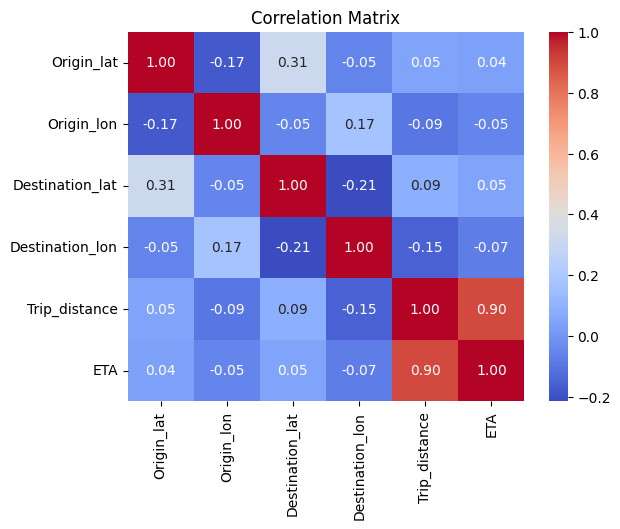

In [20]:
# Create a correlation matrix for continuous variables
train = training.drop('Timestamp', axis=1)
correlation_matrix = train.corr()

# Display the correlation matrix with a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Correlation Matrix')
plt.show()

## 3. Data Preparation

### Feature Processing & Engineering
Here is the section to **clean**, **process** the dataset and **create new features**.

In [21]:
training.reset_index(inplace=True)
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83924 entries, 0 to 83923
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   ID               83924 non-null  object             
 1   Timestamp        83924 non-null  datetime64[ns, UTC]
 2   Origin_lat       83924 non-null  float64            
 3   Origin_lon       83924 non-null  float64            
 4   Destination_lat  83924 non-null  float64            
 5   Destination_lon  83924 non-null  float64            
 6   Trip_distance    83924 non-null  int64              
 7   ETA              83924 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(2), object(1)
memory usage: 5.1+ MB


In [22]:
# drop 'ID' column
training.drop(['ID'],axis=1, inplace = True)

#### Merge training data and weather data

In [23]:
# Merge 'Weather' and 'training' on date column

training['date']=training['Timestamp'].dt.date
training['date']=pd.to_datetime(training['date'])
training_merged=pd.merge(training,weather_df, how='left', on='date')
print(training_merged.shape)
training_merged.head()

(83924, 17)


,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,2019-12-04,283.048,288.319,286.984,"100,523.062",286.002,"99,474.219",0.006,1.915,2.438
1,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576,2019-12-10,282.287,289.169,286.989,"102,472.148",283.799,"101,401.242",0.001,2.550,-1.545
2,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526,2019-11-23,284.371,292.537,289.942,"100,172.914",287.650,"99,133.383",0.009,6.638,3.548
3,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130,2019-12-01,284.529,292.346,288.692,"101,382.914",285.940,"100,338.461",0.000,-0.076,1.090
4,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138,2019-12-17,281.458,292.584,291.201,"100,634.461",287.550,"99,595.820",0.001,-1.771,2.671


#### Extract date-time features

In [24]:
def add_date_features(df,timestamp_id):

    df.loc[:, 'pickup_weekday'] = df[timestamp_id].dt.weekday
    df.loc[:, 'pickup_hour'] = df[timestamp_id].dt.hour
    df.loc[:, 'pickup_minute'] = df[timestamp_id].dt.minute
    df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']

In [25]:
# call function
add_date_features(training_merged,'Timestamp')

In [26]:
training_merged.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,date,dewpoint_2m_temperature,maximum_2m_air_temperature,...,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,pickup_weekday,pickup_hour,pickup_minute,pickup_week_hour
0,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,2019-12-04,283.048,288.319,...,"100,523.062",286.002,"99,474.219",0.006,1.915,2.438,2,20,1,68
1,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576,2019-12-10,282.287,289.169,...,"102,472.148",283.799,"101,401.242",0.001,2.550,-1.545,1,22,37,46
2,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526,2019-11-23,284.371,292.537,...,"100,172.914",287.650,"99,133.383",0.009,6.638,3.548,5,20,36,140
3,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130,2019-12-01,284.529,292.346,...,"101,382.914",285.940,"100,338.461",0.000,-0.076,1.090,6,5,43,149
4,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138,2019-12-17,281.458,292.584,...,"100,634.461",287.550,"99,595.820",0.001,-1.771,2.671,1,20,30,44


#### Clustering coordinates

In [27]:
#trip clustering
kmean=KMeans(n_clusters=10,random_state=42)

coords = training_merged[['Origin_lat'	,'Origin_lon'	,'Destination_lat'	,'Destination_lon']]

training_merged["cluster_id"]=kmean.fit_predict(coords)

In [28]:
training_merged.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,date,dewpoint_2m_temperature,maximum_2m_air_temperature,...,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,pickup_weekday,pickup_hour,pickup_minute,pickup_week_hour,cluster_id
0,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,2019-12-04,283.048,288.319,...,286.002,"99,474.219",0.006,1.915,2.438,2,20,1,68,0
1,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576,2019-12-10,282.287,289.169,...,283.799,"101,401.242",0.001,2.550,-1.545,1,22,37,46,3
2,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526,2019-11-23,284.371,292.537,...,287.650,"99,133.383",0.009,6.638,3.548,5,20,36,140,3
3,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130,2019-12-01,284.529,292.346,...,285.940,"100,338.461",0.000,-0.076,1.090,6,5,43,149,0
4,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138,2019-12-17,281.458,292.584,...,287.550,"99,595.820",0.001,-1.771,2.671,1,20,30,44,9


In [29]:
# Add weather features

# temperature_range
training_merged['temperature_range'] = training_merged['maximum_2m_air_temperature'] - training_merged['minimum_2m_air_temperature']

# Calculate wind speed
training_merged['wind_speed'] = np.sqrt(training_merged['u_component_of_wind_10m']**2 + training_merged['v_component_of_wind_10m']**2)

# Rain
training_merged['rain'] = (training_merged['total_precipitation'] > 0).astype(int)

In [30]:
#drop columns
training_merged = training_merged.drop(columns= ['date', 'surface_pressure', 'u_component_of_wind_10m', 'v_component_of_wind_10m'],axis=1)

In [31]:
training_merged = training_merged.set_index('Timestamp')
training_merged.sort_index(ascending=True, inplace=True)
training_merged.head()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,total_precipitation,pickup_weekday,pickup_hour,pickup_minute,pickup_week_hour,cluster_id,temperature_range,wind_speed,rain
Timestamp,,,,,,,,,,,,,,,,,,,,
2019-11-19 23:00:08+00:00,3.021,36.751,3.031,36.769,3898,556,281.223,288.498,285.203,"101,709.281",282.854,0.003,1,23,0,47,5,5.644,3.318,1
2019-11-19 23:00:10+00:00,2.972,36.760,3.006,36.728,5861,785,281.223,288.498,285.203,"101,709.281",282.854,0.003,1,23,0,47,1,5.644,3.318,1
2019-11-19 23:00:38+00:00,2.850,36.682,3.048,36.784,26065,1661,281.223,288.498,285.203,"101,709.281",282.854,0.003,1,23,0,47,8,5.644,3.318,1
2019-11-19 23:00:44+00:00,2.984,36.757,3.005,36.777,4943,629,281.223,288.498,285.203,"101,709.281",282.854,0.003,1,23,0,47,1,5.644,3.318,1
2019-11-19 23:00:53+00:00,2.861,36.761,3.186,36.721,37492,2181,281.223,288.498,285.203,"101,709.281",282.854,0.003,1,23,0,47,9,5.644,3.318,1


In [32]:
training_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83924 entries, 2019-11-19 23:00:08+00:00 to 2019-12-19 23:59:29+00:00
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Origin_lat                  83924 non-null  float64
 1   Origin_lon                  83924 non-null  float64
 2   Destination_lat             83924 non-null  float64
 3   Destination_lon             83924 non-null  float64
 4   Trip_distance               83924 non-null  int64  
 5   ETA                         83924 non-null  int64  
 6   dewpoint_2m_temperature     83924 non-null  float64
 7   maximum_2m_air_temperature  83924 non-null  float64
 8   mean_2m_air_temperature     83924 non-null  float64
 9   mean_sea_level_pressure     83924 non-null  float64
 10  minimum_2m_air_temperature  83924 non-null  float64
 11  total_precipitation         83924 non-null  float64
 12  pickup_weekday              83924 non-nul

In [36]:
# confirm our dataset is clean. remove null and infinite values

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame)
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

clean_dataset(training_merged)

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,total_precipitation,pickup_weekday,pickup_hour,pickup_minute,pickup_week_hour,cluster_id,temperature_range,wind_speed,rain
Timestamp,,,,,,,,,,,,,,,,,,,,
2019-11-19 23:00:08+00:00,3.021,36.751,3.031,36.769,"3,898.000",556.000,281.223,288.498,285.203,"101,709.281",282.854,0.003,1.000,23.000,0.000,47.000,5.000,5.644,3.318,1.000
2019-11-19 23:00:10+00:00,2.972,36.760,3.006,36.728,"5,861.000",785.000,281.223,288.498,285.203,"101,709.281",282.854,0.003,1.000,23.000,0.000,47.000,1.000,5.644,3.318,1.000
2019-11-19 23:00:38+00:00,2.850,36.682,3.048,36.784,"26,065.000","1,661.000",281.223,288.498,285.203,"101,709.281",282.854,0.003,1.000,23.000,0.000,47.000,8.000,5.644,3.318,1.000
2019-11-19 23:00:44+00:00,2.984,36.757,3.005,36.777,"4,943.000",629.000,281.223,288.498,285.203,"101,709.281",282.854,0.003,1.000,23.000,0.000,47.000,1.000,5.644,3.318,1.000
2019-11-19 23:00:53+00:00,2.861,36.761,3.186,36.721,"37,492.000","2,181.000",281.223,288.498,285.203,"101,709.281",282.854,0.003,1.000,23.000,0.000,47.000,9.000,5.644,3.318,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19 23:58:39+00:00,3.052,36.773,2.980,36.754,"11,650.000","1,019.000",280.996,290.565,286.987,"101,902.789",284.714,0.000,3.000,23.000,58.000,95.000,5.000,5.851,2.932,1.000
2019-12-19 23:59:01+00:00,3.052,36.773,2.980,36.753,"11,650.000","1,019.000",280.996,290.565,286.987,"101,902.789",284.714,0.000,3.000,23.000,59.000,95.000,5.000,5.851,2.932,1.000
2019-12-19 23:59:21+00:00,3.063,36.724,3.074,36.752,"8,191.000",926.000,280.996,290.565,286.987,"101,902.789",284.714,0.000,3.000,23.000,59.000,95.000,3.000,5.851,2.932,1.000


In [37]:
training_merged.describe()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,total_precipitation,pickup_weekday,pickup_hour,pickup_minute,pickup_week_hour,cluster_id,temperature_range,wind_speed,rain
count,"83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000","83,924.000"
mean,3.052,36.739,3.057,36.738,"13,527.821","1,111.698",283.662,291.342,288.556,"101,512.124",285.693,0.001,3.003,15.312,28.844,87.391,4.002,5.649,3.612,0.825
std,0.096,0.032,0.101,0.033,"9,296.716",563.565,1.777,1.648,1.349,570.615,1.314,0.003,1.904,8.779,17.511,46.257,2.583,1.831,2.199,0.380
min,2.807,36.589,2.807,36.596,1.000,1.000,279.517,288.201,285.203,"100,172.914",282.348,-0.000,0.000,0.000,0.000,0.000,0.000,2.076,0.803,0.000
25%,2.994,36.721,2.995,36.718,"6,108.000",701.000,282.495,290.306,287.433,"101,204.844",285.041,0.000,1.000,5.000,13.000,47.000,2.000,4.886,2.074,1.000
50%,3.046,36.742,3.049,36.742,"11,731.500","1,054.000",283.759,291.370,288.459,"101,586.086",285.602,0.000,3.000,20.000,29.000,92.000,4.000,5.851,3.014,1.000
75%,3.095,36.760,3.109,36.760,"19,369.000","1,456.000",284.881,292.537,289.742,"102,011.875",286.304,0.001,5.000,22.000,44.000,120.000,5.000,6.695,4.994,1.000
max,3.381,36.820,3.381,36.819,"62,028.000","5,238.000",286.327,294.420,291.593,"102,472.148",287.693,0.009,6.000,23.000,59.000,167.000,9.000,9.166,9.887,1.000


#### X and Y split

In [38]:
X =training_merged.drop('ETA',axis=1)
X.head()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,total_precipitation,pickup_weekday,pickup_hour,pickup_minute,pickup_week_hour,cluster_id,temperature_range,wind_speed,rain
Timestamp,,,,,,,,,,,,,,,,,,,
2019-11-19 23:00:08+00:00,3.021,36.751,3.031,36.769,3898,281.223,288.498,285.203,"101,709.281",282.854,0.003,1,23,0,47,5,5.644,3.318,1
2019-11-19 23:00:10+00:00,2.972,36.760,3.006,36.728,5861,281.223,288.498,285.203,"101,709.281",282.854,0.003,1,23,0,47,1,5.644,3.318,1
2019-11-19 23:00:38+00:00,2.850,36.682,3.048,36.784,26065,281.223,288.498,285.203,"101,709.281",282.854,0.003,1,23,0,47,8,5.644,3.318,1
2019-11-19 23:00:44+00:00,2.984,36.757,3.005,36.777,4943,281.223,288.498,285.203,"101,709.281",282.854,0.003,1,23,0,47,1,5.644,3.318,1
2019-11-19 23:00:53+00:00,2.861,36.761,3.186,36.721,37492,281.223,288.498,285.203,"101,709.281",282.854,0.003,1,23,0,47,9,5.644,3.318,1


In [39]:
y = training_merged["ETA"]
y.head()

Timestamp
2019-11-19 23:00:08+00:00     556
2019-11-19 23:00:10+00:00     785
2019-11-19 23:00:38+00:00    1661
2019-11-19 23:00:44+00:00     629
2019-11-19 23:00:53+00:00    2181
Name: ETA, dtype: int64

#### Train - Test Split

In [40]:
83924 * 0.2

16784.8

In [41]:
X_train = X.iloc[:-17000]
X_test = X.iloc[-17000:]
X_train.shape,X_test.shape

((66924, 19), (17000, 19))

In [42]:
y_train = y.iloc[:-17000]
y_test = y.iloc[-17000:]
y_train.shape,y_test.shape

((66924,), (17000,))

In [43]:
# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [44]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

feature_names = X.columns.tolist()


# Get the indices of features sorted by scores in descending order
sorted_indices = sorted(range(len(fs.scores_)), key=lambda i: fs.scores_[i], reverse=True)

# Display feature names along with scores
for i in sorted_indices:
    print(f'Feature {i}: {feature_names[i]}, Score: {fs.scores_[i]}.')


Feature 4: Trip_distance, Score: 278317.9198582755.
Feature 15: cluster_id, Score: 1365.2713902643782.
Feature 3: Destination_lon, Score: 286.93992021636853.
Feature 2: Destination_lat, Score: 144.83447956367877.
Feature 1: Origin_lon, Score: 132.90536668074776.
Feature 0: Origin_lat, Score: 82.73121781936533.
Feature 5: dewpoint_2m_temperature, Score: 71.37131680429084.
Feature 9: minimum_2m_air_temperature, Score: 28.617167825882554.
Feature 18: rain, Score: 28.41630906332127.
Feature 14: pickup_week_hour, Score: 24.230300303340005.
Feature 16: temperature_range, Score: 20.887605133931885.
Feature 11: pickup_weekday, Score: 18.648928510222188.
Feature 12: pickup_hour, Score: 11.55378472952428.
Feature 7: mean_2m_air_temperature, Score: 8.914625671640605.
Feature 13: pickup_minute, Score: 5.995221220218257.
Feature 8: mean_sea_level_pressure, Score: 3.595424142475191.
Feature 10: total_precipitation, Score: 3.069486711792479.
Feature 6: maximum_2m_air_temperature, Score: 0.36803994111

In [45]:
X_train = X_train.drop(columns= ['wind_speed', 'maximum_2m_air_temperature', 'total_precipitation',
                                 'mean_sea_level_pressure' , 'pickup_minute','mean_2m_air_temperature'
                                 ],axis=1)

X_test = X_test.drop(columns= ['wind_speed', 'maximum_2m_air_temperature', 'total_precipitation',
                                 'mean_sea_level_pressure' , 'pickup_minute','mean_2m_air_temperature'
                                 ],axis=1)

In [46]:
X_train.shape, X_test.shape

((66924, 13), (17000, 13))

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66924 entries, 2019-11-19 23:00:08+00:00 to 2019-12-13 21:13:39+00:00
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Origin_lat                  66924 non-null  float64
 1   Origin_lon                  66924 non-null  float64
 2   Destination_lat             66924 non-null  float64
 3   Destination_lon             66924 non-null  float64
 4   Trip_distance               66924 non-null  int64  
 5   dewpoint_2m_temperature     66924 non-null  float64
 6   minimum_2m_air_temperature  66924 non-null  float64
 7   pickup_weekday              66924 non-null  int32  
 8   pickup_hour                 66924 non-null  int32  
 9   pickup_week_hour            66924 non-null  int32  
 10  cluster_id                  66924 non-null  int32  
 11  temperature_range           66924 non-null  float64
 12  rain                        66924 non-nul

In [48]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17000 entries, 2019-12-13 21:13:39+00:00 to 2019-12-19 23:59:29+00:00
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Origin_lat                  17000 non-null  float64
 1   Origin_lon                  17000 non-null  float64
 2   Destination_lat             17000 non-null  float64
 3   Destination_lon             17000 non-null  float64
 4   Trip_distance               17000 non-null  int64  
 5   dewpoint_2m_temperature     17000 non-null  float64
 6   minimum_2m_air_temperature  17000 non-null  float64
 7   pickup_weekday              17000 non-null  int32  
 8   pickup_hour                 17000 non-null  int32  
 9   pickup_week_hour            17000 non-null  int32  
 10  cluster_id                  17000 non-null  int32  
 11  temperature_range           17000 non-null  float64
 12  rain                        17000 non-nul

#### Pipeline

In [49]:
input_features =X_train.columns
input_features

Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'dewpoint_2m_temperature',
       'minimum_2m_air_temperature', 'pickup_weekday', 'pickup_hour',
       'pickup_week_hour', 'cluster_id', 'temperature_range', 'rain'],
      dtype='object')

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), input_features),
        ('log_transformer',FunctionTransformer(np.log1p),input_features)
    ]
)

## 4. Machine Learning Modeling 
Here is the section to **build**, **train**, **evaluate** and **compare** the models to each others.

### Baseline

In [51]:
mean_baseline = y_train.mean()
median_baseline = y_train.median()

# Calculate RMSE for the baseline models
rmse_mean_baseline = np.sqrt(mean_squared_error(y_train, [mean_baseline] * len(y_train)))
rmse_median_baseline = np.sqrt(mean_squared_error(y_train, [median_baseline] * len(y_train)))

print(f'RMSE for Mean Baseline: {rmse_mean_baseline}')
print(f'RMSE for Median Baseline: {rmse_median_baseline}')

RMSE for Mean Baseline: 567.6385140464366
RMSE for Median Baseline: 570.585294995918


#### Linear Regression

In [52]:
# create and fit model
LR = LinearRegression()
pipeline_LR =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('Linear Regression',LR)
])

pipeline_LR.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('Linear Regression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('scaler', ...), ('log_transformer', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of th

In [53]:
predictions = pipeline_LR.predict(X_test)
data = {'Actual': y_test, 'Predicted': predictions}
df_predictions = pd.DataFrame(data)
df_predictions.head(10)

,Actual,Predicted
Timestamp,,
2019-12-13 21:13:39+00:00,862,"1,015.203"
2019-12-13 21:13:43+00:00,1766,"1,558.532"
2019-12-13 21:13:56+00:00,1464,"1,647.800"
2019-12-13 21:14:17+00:00,124,90.412
2019-12-13 21:14:24+00:00,1516,"1,652.431"
2019-12-13 21:14:49+00:00,790,"1,174.801"
2019-12-13 21:14:54+00:00,1183,"1,282.393"
2019-12-13 21:15:01+00:00,1516,"1,652.027"
2019-12-13 21:15:07+00:00,1097,"1,048.005"


In [54]:
# Predicting and Evaluating the Linear Regression model

mse = mean_squared_error(y_test, predictions)
lr_rmse = np.sqrt(mse)
print(mse)
print(lr_rmse)

47482.161869379954
217.90401985594474


In [55]:
lr_scores = cross_val_score(pipeline_LR, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)

lr_rmse_scores = np.sqrt(-lr_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(lr_rmse_scores)

Scores: [217.33877257 217.93338456 232.45750965 234.1204996  218.9959892
 239.39845037 245.45505996 207.3838721  233.80909283 199.83128285]
Mean: 224.67239136759412
Standard deviation: 13.890721890527058


#### KNN

In [56]:
# create and fit model

KNN = KNeighborsRegressor(n_neighbors = 5, \
                           metric = 'minkowski', p = 2)
pipeline_KNN =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('K-Nearest Neighbors',KNN)
])

pipeline_KNN.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('K-Nearest Neighbors', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('scaler', ...), ('log_transformer', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

In [57]:
predictions_knn = pipeline_KNN.predict(X_test)
data = {'Actual': y_test, 'Predicted': predictions_knn}
df_predictions = pd.DataFrame(data)
df_predictions.head(10)

,Actual,Predicted
Timestamp,,
2019-12-13 21:13:39+00:00,862,835.800
2019-12-13 21:13:43+00:00,1766,"1,511.600"
2019-12-13 21:13:56+00:00,1464,"1,256.200"
2019-12-13 21:14:17+00:00,124,195.200
2019-12-13 21:14:24+00:00,1516,"1,606.800"
2019-12-13 21:14:49+00:00,790,"1,068.800"
2019-12-13 21:14:54+00:00,1183,"1,219.400"
2019-12-13 21:15:01+00:00,1516,"1,606.800"
2019-12-13 21:15:07+00:00,1097,"1,155.600"


In [58]:
# Predicting and Evaluating the nearest neighbors model

mse = mean_squared_error(y_test, predictions_knn)
knn_rmse = np.sqrt(mse)
print(mse)
print(knn_rmse)

55894.161468235296
236.41946084921878


In [59]:
knn_scores = cross_val_score(pipeline_KNN, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)

knn_rmse_scores = np.sqrt(-knn_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(knn_rmse_scores)

Scores: [233.34608986 264.42872653 257.50113035 270.87413494 227.48295307
 272.61600937 291.58932629 225.07807609 266.466406   231.57933696]
Mean: 254.09621894567508
Standard deviation: 21.88489486010766


#### Decision Tree

In [60]:
# create and fit model

DT = DecisionTreeRegressor()
pipeline_DT =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('Decision Tree',DT)
])

pipeline_DT.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('Decision Tree', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('scaler', ...), ('log_transformer', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the di

In [61]:
predictions_dt = pipeline_DT.predict(X_test)
data = {'Actual': y_test, 'Predicted': predictions_dt}
df_predictions = pd.DataFrame(data)
df_predictions.head(10)

,Actual,Predicted
Timestamp,,
2019-12-13 21:13:39+00:00,862,891.000
2019-12-13 21:13:43+00:00,1766,"1,766.000"
2019-12-13 21:13:56+00:00,1464,"1,581.000"
2019-12-13 21:14:17+00:00,124,79.000
2019-12-13 21:14:24+00:00,1516,"1,882.000"
2019-12-13 21:14:49+00:00,790,"1,269.000"
2019-12-13 21:14:54+00:00,1183,"1,139.000"
2019-12-13 21:15:01+00:00,1516,"1,882.000"
2019-12-13 21:15:07+00:00,1097,"1,117.000"


In [62]:
# Predicting and Evaluating the decesion tree model

mse = mean_squared_error(y_test, predictions_dt)
dt_rmse = np.sqrt(mse)
print(mse)
print(dt_rmse)

65718.15691135621
256.3555283417079


In [63]:
dt_scores = cross_val_score(pipeline_DT, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)

dtree_rmse_scores = np.sqrt(-dt_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(dtree_rmse_scores)

Scores: [264.91162205 244.00230887 251.57672344 262.15592414 241.37465906
 274.77416841 261.90548663 228.18818842 266.16241937 236.85155311]
Mean: 253.19030534813146
Standard deviation: 14.305795873739358


#### Random Forest

In [64]:
# create and fit model

RF = RandomForestRegressor(n_estimators = 300, max_features = 
                           'sqrt', max_depth = 5)
pipeline_RF =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('Random Forest',RF)
])

pipeline_RF.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('Random Forest', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('scaler', ...), ('log_transformer', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the di

In [65]:
predictions_rf = pipeline_RF.predict(X_test)
data = {'Actual': y_test, 'Predicted': predictions_rf}
df_predictions = pd.DataFrame(data)
df_predictions.head(10)

,Actual,Predicted
Timestamp,,
2019-12-13 21:13:39+00:00,862,880.061
2019-12-13 21:13:43+00:00,1766,"1,469.059"
2019-12-13 21:13:56+00:00,1464,"1,380.997"
2019-12-13 21:14:17+00:00,124,501.303
2019-12-13 21:14:24+00:00,1516,"1,658.746"
2019-12-13 21:14:49+00:00,790,"1,165.981"
2019-12-13 21:14:54+00:00,1183,"1,333.677"
2019-12-13 21:15:01+00:00,1516,"1,658.746"
2019-12-13 21:15:07+00:00,1097,"1,239.361"


In [66]:
# Predicting and Evaluating the random forest model

mse = mean_squared_error(y_test, predictions_rf)
rf_rmse = np.sqrt(mse)
print(mse)
print(rf_rmse)

58095.12153463311
241.02929600908084


In [67]:
rf_scores = cross_val_score(pipeline_RF, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)

forest_rmse_scores = np.sqrt(-rf_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(forest_rmse_scores)

Scores: [238.75761423 239.06788551 254.1452728  264.00988642 240.14250983
 262.79270678 280.06502983 231.14489408 255.78708025 220.49426108]
Mean: 248.64071408109504
Standard deviation: 16.926929464693924


#### XGBOOST

In [68]:
# create and fit model
XGB = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
pipeline_XGB =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('XGBOOST',XGB)
])

pipeline_XGB.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('XGBOOST', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('scaler', ...), ('log_transformer', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the differen

In [69]:
predictions_xgb = pipeline_XGB.predict(X_test)
data = {'Actual': y_test, 'Predicted': predictions_xgb}
df_predictions = pd.DataFrame(data)
df_predictions.head(10)

,Actual,Predicted
Timestamp,,
2019-12-13 21:13:39+00:00,862,871.850
2019-12-13 21:13:43+00:00,1766,"1,752.006"
2019-12-13 21:13:56+00:00,1464,"1,573.525"
2019-12-13 21:14:17+00:00,124,92.282
2019-12-13 21:14:24+00:00,1516,"1,547.782"
2019-12-13 21:14:49+00:00,790,848.805
2019-12-13 21:14:54+00:00,1183,"1,152.179"
2019-12-13 21:15:01+00:00,1516,"1,589.113"
2019-12-13 21:15:07+00:00,1097,"1,144.815"


In [70]:
# Predicting and Evaluating the xgboost model

mse = mean_squared_error(y_test, predictions_xgb)
xgb_rmse = np.sqrt(mse)
print(mse)
print(xgb_rmse)

23379.4921875
152.903538832494


In [71]:
xgb_scores = cross_val_score(pipeline_XGB, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(xgb_rmse_scores)

Scores: [136.93655151 154.50829266 154.77768835 154.19112911 134.85576786
 168.73250488 155.73625541 132.03925641 167.86437746 137.60402315]
Mean: 149.72458468134022
Standard deviation: 12.802950397278938


#### LIGHTGBM

In [72]:
# create and fit model
LGBM = LGBMRegressor()
pipeline_LGBM =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('LightGBM',LGBM)
])

pipeline_LGBM.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2631
[LightGBM] [Info] Number of data points in the train set: 66924, number of used features: 26
[LightGBM] [Info] Start training from score 1114.914560


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('LightGBM', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('scaler', ...), ('log_transformer', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the differe

In [73]:
predictions_lgbm = pipeline_LGBM.predict(X_test)
data = {'Actual': y_test, 'Predicted': predictions_lgbm}
df_predictions = pd.DataFrame(data)
df_predictions.head(10)

c:\Users\Aobando\Desktop\Code\Estimated-Time-of-Arrival-ETA-Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Actual,Predicted
Timestamp,,
2019-12-13 21:13:39+00:00,862,954.745
2019-12-13 21:13:43+00:00,1766,"1,691.704"
2019-12-13 21:13:56+00:00,1464,"1,537.996"
2019-12-13 21:14:17+00:00,124,135.951
2019-12-13 21:14:24+00:00,1516,"1,705.229"
2019-12-13 21:14:49+00:00,790,"1,212.082"
2019-12-13 21:14:54+00:00,1183,"1,212.490"
2019-12-13 21:15:01+00:00,1516,"1,693.079"
2019-12-13 21:15:07+00:00,1097,"1,052.075"


In [74]:
# Predicting and Evaluating the lgbmregressor model

mse = mean_squared_error(y_test, predictions_lgbm)
lgbm_rmse = np.sqrt(mse)
print(mse)
print(lgbm_rmse)

29022.14472971263
170.35887041687212


### Evaluation

In [75]:
# Create a dictionary for accuracy
accuracy_results = {
    'Linear Regression': lr_rmse,
    'RandomForest': rf_rmse,
    'XGB' :xgb_rmse,
    'Decision Tree':dt_rmse,
    'KNN':knn_rmse,
    'LGBM':lgbm_rmse
}

df = pd.DataFrame(list(accuracy_results.items()), columns=['Model', 'RSME'])

# show the result
df_sorted = df.sort_values(by='RSME', ascending=True)
df_sorted

,Model,RSME
2,XGB,152.904
5,LGBM,170.359
0,Linear Regression,217.904
4,KNN,236.419
1,RandomForest,241.029
3,Decision Tree,256.356


### Hyperparameter Tuning

In [76]:
# Check current model parameters
current_params = XGB.get_params()
current_params

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1000,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.7,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.1}

In [77]:
params = {
        'n_estimators': [1000,2000,3000],
        'max_depth': [5,6,7],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'subsample': [0.6, 0.7, 0.8],
        'min_child_weight': [1, 3, 5],
        'gamma':[0, 0.1,0.2],
        'learning_rate': [0.1, 0.01, 0.05]
        }

random_search = RandomizedSearchCV(XGB, params,
                           cv=5, scoring='neg_mean_squared_error',return_train_score=True,
                           verbose=1, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...obs=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.6, 0.7, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.1, 0.01, ...], 'max_depth': [5, 6, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can 

In [78]:
# Get the best hyperparameters and best model from random search
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'subsample': 0.7, 'n_estimators': 3000, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}


In [79]:
best_model

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.6
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_meth

In [80]:
pipeline_XGB2 =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('XGBOOST',best_model)
])

pipeline_XGB2.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('XGBOOST', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('scaler', ...), ('log_transformer', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the differen

In [81]:
predictions_xgbtuned = pipeline_XGB2.predict(X_test)
data = {'Actual': y_test, 'Predicted': predictions_xgbtuned}
df_predictions = pd.DataFrame(data)
df_predictions.head(10)

,Actual,Predicted
Timestamp,,
2019-12-13 21:13:39+00:00,862,848.539
2019-12-13 21:13:43+00:00,1766,"1,708.633"
2019-12-13 21:13:56+00:00,1464,"1,572.358"
2019-12-13 21:14:17+00:00,124,139.481
2019-12-13 21:14:24+00:00,1516,"1,557.617"
2019-12-13 21:14:49+00:00,790,866.613
2019-12-13 21:14:54+00:00,1183,"1,131.655"
2019-12-13 21:15:01+00:00,1516,"1,573.634"
2019-12-13 21:15:07+00:00,1097,"1,111.234"


In [82]:
mse = mean_squared_error(y_test, predictions_xgbtuned)
xgbtuned_rmse = np.sqrt(mse)
print(mse)
print(xgbtuned_rmse)

23027.2265625
151.74724565045653


In [83]:
xgb2_scores = cross_val_score(pipeline_XGB2, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
xgb2_rmse_scores = np.sqrt(-xgb2_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(xgb2_rmse_scores)

Scores: [136.27560683 148.94380757 151.30506487 152.14518791 130.98200318
 165.75602718 154.04376154 130.38606287 163.07339342 133.95668172]
Mean: 146.68675970772847
Standard deviation: 12.35030660842587


### Save model

In [84]:
destination = "../toolkit"

#create a directory if it doesn't exist
if not os.path.exists(destination):
    os.makedirs(destination)

#Create a dictionary  to store the object and their filename
models ={
    "pipeline":pipeline_XGB2
}

#Loop through the model and save them using joblib.dump()
for name,model in models.items():
    file_path =os.path.join(destination,f"{name}.joblib")
    joblib.dump(model,file_path)

### Model Predictions on Unseen Data

In [85]:
# Load the model

loaded_model = load('../toolkit/pipeline.joblib')

In [86]:
testing.reset_index(inplace=True)
testing.head()

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance
0,000V4BQX,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549
1,003WBC5J,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532
2,004O4X3A,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194
3,006CEI5B,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768
4,009G0M2T,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513


In [87]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35625 entries, 0 to 35624
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   ID               35625 non-null  object             
 1   Timestamp        35625 non-null  datetime64[ns, UTC]
 2   Origin_lat       35625 non-null  float64            
 3   Origin_lon       35625 non-null  float64            
 4   Destination_lat  35625 non-null  float64            
 5   Destination_lon  35625 non-null  float64            
 6   Trip_distance    35625 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(1)
memory usage: 1.9+ MB


In [89]:
testing['Timestamp'].min(), testing['Timestamp'].max()

(Timestamp('2019-12-20 00:00:01+0000', tz='UTC'),
 Timestamp('2019-12-31 22:59:57+0000', tz='UTC'))

In [91]:
weather_df['date'].min(), weather_df['date'].max()

(Timestamp('2019-11-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [92]:
id_column = testing['ID']

In [93]:
# drop 'ID' column
testing.drop(['ID'],axis=1, inplace = True)

In [94]:
# Merge 'Weather' and 'testing' on date column

testing['date']=testing['Timestamp'].dt.date
testing['date']=pd.to_datetime(testing['date'])
testing_merged=pd.merge(testing,weather_df, how='left', on='date')
print(testing_merged.shape)
testing_merged.head()

(35625, 16)


,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549,2019-12-21,284.806,294.207,293.213,"101,113.445",292.543,"100,074.289",0.000,8.243,4.163
1,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532,2019-12-25,282.767,293.182,287.179,"102,420.648",283.159,"101,367.805",-0.000,-0.947,0.584
2,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194,2019-12-29,281.217,288.780,285.633,"103,071.938",283.223,"101,990.836",0.000,-2.151,-0.673
3,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768,2019-12-31,279.129,288.595,285.817,"103,213.500",282.038,"102,129.195",0.000,-0.852,-0.922
4,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513,2019-12-28,281.909,289.480,285.969,"102,934.477",282.803,"101,858.836",0.000,-2.373,-0.185


In [95]:
add_date_features(testing_merged,'Timestamp')
testing_merged.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,pickup_weekday,pickup_hour,pickup_minute,pickup_week_hour
0,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549,2019-12-21,284.806,294.207,293.213,"101,113.445",292.543,"100,074.289",0.000,8.243,4.163,5,5,52,125
1,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532,2019-12-25,282.767,293.182,287.179,"102,420.648",283.159,"101,367.805",-0.000,-0.947,0.584,2,21,38,69
2,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194,2019-12-29,281.217,288.780,285.633,"103,071.938",283.223,"101,990.836",0.000,-2.151,-0.673,6,21,30,165
3,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768,2019-12-31,279.129,288.595,285.817,"103,213.500",282.038,"102,129.195",0.000,-0.852,-0.922,1,22,51,46
4,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513,2019-12-28,281.909,289.480,285.969,"102,934.477",282.803,"101,858.836",0.000,-2.373,-0.185,5,21,47,141


In [96]:
#trip clustering
kmean=KMeans(n_clusters=10,random_state=42)

coords = testing_merged[['Origin_lat'	,'Origin_lon'	,'Destination_lat'	,'Destination_lon']]

#cleaned["cluster_id"]=cleaned["cluster_id"].astype('category')

testing_merged["cluster_id"]=kmean.fit_predict(coords)

In [97]:
# Add weather features

# temperature_range
testing_merged['temperature_range'] = testing_merged['maximum_2m_air_temperature'] - testing_merged['minimum_2m_air_temperature']

# Calculate wind speed
testing_merged['wind_speed'] = np.sqrt(testing_merged['u_component_of_wind_10m']**2 + testing_merged['v_component_of_wind_10m']**2)

# Rain
testing_merged['rain'] = (testing_merged['total_precipitation'] > 0).astype(int)

In [98]:
testing_merged = testing_merged.drop(columns= ['date', 'surface_pressure', 'u_component_of_wind_10m', 'v_component_of_wind_10m'],axis=1)

In [99]:
testing_merged = testing_merged.set_index('Timestamp')
testing_merged.sort_index(ascending=True, inplace=True)
testing_merged.head()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,total_precipitation,pickup_weekday,pickup_hour,pickup_minute,pickup_week_hour,cluster_id,temperature_range,wind_speed,rain
Timestamp,,,,,,,,,,,,,,,,,,,
2019-12-20 00:00:01+00:00,3.070,36.743,3.079,36.723,3228,281.593,293.419,290.122,"101,216.570",285.235,0.001,4,0,0,96,5,8.184,5.138,1
2019-12-20 00:00:34+00:00,3.071,36.743,3.079,36.723,3228,281.593,293.419,290.122,"101,216.570",285.235,0.001,4,0,0,96,5,8.184,5.138,1
2019-12-20 00:01:09+00:00,3.026,36.761,3.036,36.805,11308,281.593,293.419,290.122,"101,216.570",285.235,0.001,4,0,1,96,8,8.184,5.138,1
2019-12-20 00:01:12+00:00,3.001,36.708,3.208,36.698,25521,281.593,293.419,290.122,"101,216.570",285.235,0.001,4,0,1,96,2,8.184,5.138,1
2019-12-20 00:01:22+00:00,2.965,36.772,2.986,36.675,18805,281.593,293.419,290.122,"101,216.570",285.235,0.001,4,0,1,96,6,8.184,5.138,1


In [100]:
testing_final = testing_merged.drop(columns= ['wind_speed', 'maximum_2m_air_temperature', 'total_precipitation',
                                 'mean_sea_level_pressure' , 'pickup_minute','mean_2m_air_temperature'
                                 ],axis=1)

testing_final.shape

(35625, 13)

In [101]:
New_predictions = loaded_model.predict(testing_final)
datafr = {'ID': id_column, 'ETA': New_predictions}
df_new_predictions = pd.DataFrame(datafr)
df_new_predictions.head(10)

,ID,ETA
0,000V4BQX,480.612
1,003WBC5J,449.100
2,004O4X3A,"1,446.163"
3,006CEI5B,"1,740.955"
4,009G0M2T,"1,497.805"
5,00A3ZHHB,"1,248.230"
6,00BRKED8,"1,733.597"
7,00F6T3BP,783.574
8,00HN6E8I,"1,350.814"
9,00HS3XXF,672.837


In [102]:
path = "../dataset/predictions.csv"

df_new_predictions.to_csv(path, index=False)